# M3.3 Study - Effect of K-anonymity on Titanic unalive prediction 

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import anonypy
from random import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, recall_score 

## Datasets (raw data & anonymized data)
Looking at the dataset

In [19]:
#loading dataset
titanic = sns.load_dataset('titanic')

titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


## Columns were chosen and k-anonymized with the Anonypy library
looking at the head of the anonymized data
- Sex, age, sibsp (sibling & spouse), parch (parent & child), fare, survived was choosen as the "relevant features"
- added a "count" column
- added some interesting intervals

In [20]:

titanicAnonymized = sns.load_dataset('titanic')

# print(titanicAnonymized.columns)

# print(titanicAnonymized['embarked'].value_counts())

#makes some columns categorical
catagorical = set(('sex', 'embarked')) 

for name in catagorical:
    titanicAnonymized[name] = titanicAnonymized[name].astype("category")

featureColumns = ['sex', 'age', 'sibsp', 'parch', 'fare'] # Removes: pclass, deck, 'class', 'who', 'adult_male', 'embark_town', 'alive', 'alone', 'embarked'
sensitiveColumn = "survived"

# print(featureColumns + [sensitiveColumn])

#k-anonymity using anonypy library 
p = anonypy.Preserver(titanicAnonymized, featureColumns, sensitiveColumn)
rows = p.anonymize_k_anonymity(k=4)

#new dataset with k-anonmity applied 
titanicAnonymized = pd.DataFrame(rows)

titanicAnonymized.head()

,sex,age,sibsp,parch,fare,survived,count
0,[male],[0.42-16.0],[0-1],[0-1],[7.2292-9.5],0,5
1,[male],[0.42-16.0],[0-1],[0-1],[7.2292-9.5],1,2
2,[male],[32.0],[0],[0],[7.75-10.5],0,6
3,[male],[32.0],[0],[0],[7.75-10.5],1,3
4,[female],[5.0-14.5],[0-1],[0],[7.2292-14.4542],0,2


## Processing data for training 

* every cell except survived has been generalized in order to fulfill k-anonomyziation 
* this data in its current form is not yet ready for training
* How would a model handle the intervals?

In [21]:
#based on count column repeat rows 
titanicAnonymized = titanicAnonymized.loc[titanicAnonymized.index.repeat(titanicAnonymized['count'])].reset_index(drop=True)
titanicAnonymized = titanicAnonymized.drop(columns=['count'])

def transform_cell(cell):
    # If not a list, return as-is
    if not isinstance(cell, list):
        return cell
    
    # Flatten the comma-separated string inside the list
    if len(cell) == 1 and isinstance(cell[0], str) and ',' in cell[0]:
        parts = cell[0].split(',')
    else:
        parts = cell

    # Remove any "nan" strings
    cleaned = [v for v in parts if v != "nan"]

    if len(cleaned) == 1:
        item = cleaned[0]
        # Handle range like '15.0-16.0'
        if '-' in item and not item.startswith('-') and any(char.isdigit() for char in item):
            try:
                lower, upper = map(float, item.split('-'))
                return [lower, upper]
            except ValueError:
                return item
        return item  # categorical

    elif len(cleaned) > 1:
        return cleaned

    return None  # If all were "nan", return None (or np.nan if preferred)



# Apply transformation to all cells except the last two columns (which are int)
cols_to_transform = titanicAnonymized.columns.difference(['survived', 'count'])
titanicAnonymized[cols_to_transform] = titanicAnonymized[cols_to_transform].map(transform_cell)


titanicAnonymized.head(10)



,sex,age,sibsp,parch,fare,survived
0,male,"[0.42, 16.0]","[0.0, 1.0]","[0.0, 1.0]","[7.2292, 9.5]",0
1,male,"[0.42, 16.0]","[0.0, 1.0]","[0.0, 1.0]","[7.2292, 9.5]",0
2,male,"[0.42, 16.0]","[0.0, 1.0]","[0.0, 1.0]","[7.2292, 9.5]",0
3,male,"[0.42, 16.0]","[0.0, 1.0]","[0.0, 1.0]","[7.2292, 9.5]",0
4,male,"[0.42, 16.0]","[0.0, 1.0]","[0.0, 1.0]","[7.2292, 9.5]",0
5,male,"[0.42, 16.0]","[0.0, 1.0]","[0.0, 1.0]","[7.2292, 9.5]",1
6,male,"[0.42, 16.0]","[0.0, 1.0]","[0.0, 1.0]","[7.2292, 9.5]",1
7,male,32.0,0,0,"[7.75, 10.5]",0
8,male,32.0,0,0,"[7.75, 10.5]",0
9,male,32.0,0,0,"[7.75, 10.5]",0


## Now some choices have to be made.... 
* how do we handle the ranges that the cells now are in? 
    * took the average of upper and lower bound of the range
    * also tried random variable in the interval
    * accuracy and statistical information was traded for privacy 


In [22]:
X = titanicAnonymized.copy()

for col in X.columns:
    for i in range(len(X[col])):
        if not isinstance(X[col][i], list):
            continue
        X.loc[i, col] = (X[col][i][0]+X[col][i][1])/2

X.head()

,sex,age,sibsp,parch,fare,survived
0,male,8.21,0.5,0.5,8.3646,0
1,male,8.21,0.5,0.5,8.3646,0
2,male,8.21,0.5,0.5,8.3646,0
3,male,8.21,0.5,0.5,8.3646,0
4,male,8.21,0.5,0.5,8.3646,0


## Evaluating logistic regression model on raw data

In [23]:
# Step 1: Define X (features) and y (target)
# X = titanic.drop(columns=['survived'])  # 'survived' is the target column in the Seaborn Titanic dataset
X = titanic[['sex', 'age', 'sibsp', 'parch', 'fare']].copy()
y = titanic['survived']

# Step 2: Handle missing values and encode categorical variables
X['age'] = X['age'].fillna(X['age'].mean())  # Fill missing values in 'age' with the mean
X['fare'] = X['fare'].fillna(X['fare'].mean())  # Fill missing values in 'fare' with the mean

# Encode categorical variables
X = pd.get_dummies(X, columns=['sex'], drop_first=True)  # One-hot encode 'sex' and 'embarked'
# Step 3: Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 4: Train a logistic regression model
model = LogisticRegression()
model.fit(x_train, y_train)

# Step 5: Evaluate the model
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Accuracy: {accuracy}')

raw_accuracy = accuracy

Precision: 0.8041237113402062
Recall: 0.7027027027027027
Accuracy: 0.8059701492537313


## Evaluating logistic regression model on anonymized data

In [24]:
# Step 1: Define X (features) and y (target)
# X = titanic.drop(columns=['survived'])  # 'survived' is the target column in the Seaborn Titanic dataset

X = titanicAnonymized.drop(columns=['survived']).copy()

for col in X.columns:
    for i in range(len(X[col])):
        if not isinstance(X[col][i], list):
            continue
        X.loc[i, col] = (X[col][i][0]+X[col][i][1])/2

        
y = titanicAnonymized['survived']

# Step 2: Handle missing values and encode categorical variables
# X['age'] = X['age'].fillna(X['age'].mean())  # Fill missing values in 'age' with the mean
# X['fare'] = X['fare'].fillna(X['fare'].mean())  # Fill missing values in 'fare' with the mean

# Encode categorical variables
X = pd.get_dummies(X, columns=['sex'], drop_first=True)  # One-hot encode 'sex' and 'embarked'
# Step 3: Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 4: Train a logistic regression model
model = LogisticRegression()
model.fit(x_train, y_train)

# Step 5: Evaluate the model
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f'Precision: {precision}')            
print(f'Recall: {recall}')
print(f'Accuracy: {accuracy}')

Precision: 0.7619047619047619
Recall: 0.7191011235955056
Accuracy: 0.7916666666666666


## Plot of k effect on accuracy

In [25]:
titanicAnonymized = sns.load_dataset('titanic')

featureColumns = ['sex', 'age', 'sibsp', 'parch', 'fare'] # Removes: pclass, deck, 'class', 'who', 'adult_male', 'embark_town', 'alive', 'alone', 'embarked'
sensitiveColumn = "survived"
catagorical = set(('sex', 'embarked'))

for name in catagorical:
    titanicAnonymized[name] = titanicAnonymized[name].astype("category")

anonymizedDataSets = []
k_values = range(2, 11)

for i in k_values:
    p = anonypy.Preserver(titanicAnonymized, featureColumns, sensitiveColumn)
    rows = p.anonymize_k_anonymity(k=i)
    k_anom_data = pd.DataFrame(rows)
    k_anom_data = k_anom_data.loc[k_anom_data.index.repeat(k_anom_data['count'])].reset_index(drop=True)
    k_anom_data = k_anom_data.drop(columns=['count'])
    cols_to_transform = k_anom_data.columns.difference(['survived', 'count'])
    k_anom_data[cols_to_transform] = k_anom_data[cols_to_transform].map(transform_cell)
    
    anonymizedDataSets.append(k_anom_data)

In [26]:
accuracy_list = []

for i in range(len(anonymizedDataSets)):
    dataSet = anonymizedDataSets[i]
    X = dataSet.drop(columns=['survived']).copy()
    y = dataSet['survived']

    for col in X.columns:
        for i in range(len(X[col])):
            if not isinstance(X[col][i], list):
                continue
            X.loc[i, col] = (X[col][i][0]+X[col][i][1])/2


    X = pd.get_dummies(X, columns=['sex'], drop_first=True)  # One-hot encode 'sex' and 'embarked'
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    model = LogisticRegression()
    model.fit(x_train, y_train)
    
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list.append(accuracy)

# print(k_values) 
# print(accuracy_list)

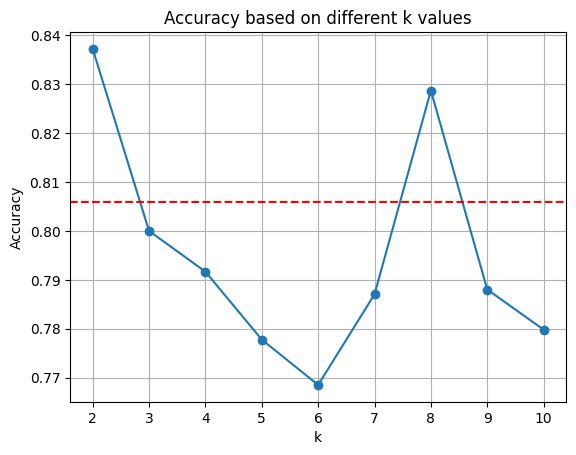

In [27]:
import matplotlib.pyplot as plt

y = k_values
x = accuracy_list

# Create the plot
plt.plot(y, x, marker='o')  # y on x-axis, x on y-axis (could reverse if needed)
plt.axhline(y=raw_accuracy, color='red', linestyle='--', label='Reference Accuracy')

# Add labels and title
plt.xlabel('k')       # Replace with your actual label
plt.ylabel('Accuracy')       # Replace with your actual label
plt.title('Accuracy based on different k values')     # Replace with your plot's title

# Optional: Show grid
plt.grid(True)

# Show the plot
plt.show()

## Plot of k effect on accuracy using random distribution  

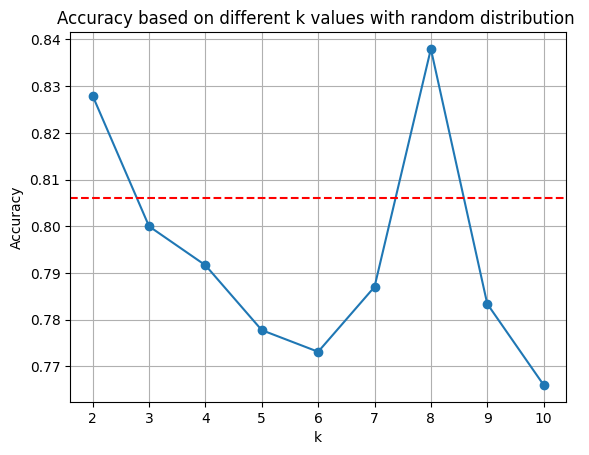

In [28]:
titanicAnonymized = sns.load_dataset('titanic')

featureColumns = ['sex', 'age', 'sibsp', 'parch', 'fare'] # Removes: pclass, deck, 'class', 'who', 'adult_male', 'embark_town', 'alive', 'alone', 'embarked'
sensitiveColumn = "survived"
catagorical = set(('sex', 'embarked'))

for name in catagorical:
    titanicAnonymized[name] = titanicAnonymized[name].astype("category")

anonymizedDataSets = []
k_values = range(2, 11)

for i in k_values:
    p = anonypy.Preserver(titanicAnonymized, featureColumns, sensitiveColumn)
    rows = p.anonymize_k_anonymity(k=i)
    k_anom_data = pd.DataFrame(rows)
    k_anom_data = k_anom_data.loc[k_anom_data.index.repeat(k_anom_data['count'])].reset_index(drop=True)
    k_anom_data = k_anom_data.drop(columns=['count'])
    cols_to_transform = k_anom_data.columns.difference(['survived', 'count'])
    k_anom_data[cols_to_transform] = k_anom_data[cols_to_transform].map(transform_cell)
    
    anonymizedDataSets.append(k_anom_data)
    
accuracy_list = []

for i in range(len(anonymizedDataSets)):
    dataSet = anonymizedDataSets[i]
    X = dataSet.drop(columns=['survived']).copy()
    y = dataSet['survived']

    for col in X.columns:
        for i in range(len(X[col])):
            if not isinstance(X[col][i], list):
                continue
            X.loc[i, col] = random() * (X[col][i][1] - X[col][i][0]) + X[col][i][0]
            
            
    X = pd.get_dummies(X, columns=['sex'], drop_first=True)  # One-hot encode 'sex' and 'embarked'
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    model = LogisticRegression()
    model.fit(x_train, y_train)
    
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list.append(accuracy)

# print(k_values) 
# print(accuracy_list

import matplotlib.pyplot as plt

y = k_values
x = accuracy_list

# Create the plot
plt.plot(y, x, marker='o')  # y on x-axis, x on y-axis (could reverse if needed)
plt.axhline(y=raw_accuracy, color='red', linestyle='--', label='Reference Accuracy')
# Add labels and title
plt.xlabel('k')       # Replace with your actual label
plt.ylabel('Accuracy')       # Replace with your actual label
plt.title('Accuracy based on different k values with random distribution ')     # Replace with your plot's title

# Optional: Show grid
plt.grid(True)

# Show the plot
plt.show()

## Plot of k effect on accuracy using only the 'fare' column

In [29]:
titanicAnonymized = sns.load_dataset('titanic')

featureColumns = ['fare'] # Removes: pclass, deck, 'class', 'who', 'adult_male', 'embark_town', 'alive', 'alone', 'embarked'
sensitiveColumn = "survived"

anonymizedDataSets = []
k_values = range(2, 11)

for i in k_values:
    p = anonypy.Preserver(titanicAnonymized, featureColumns, sensitiveColumn)
    rows = p.anonymize_k_anonymity(k=i)
    k_anom_data = pd.DataFrame(rows)
    k_anom_data = k_anom_data.loc[k_anom_data.index.repeat(k_anom_data['count'])].reset_index(drop=True)
    k_anom_data = k_anom_data.drop(columns=['count'])
    cols_to_transform = k_anom_data.columns.difference(['survived', 'count'])
    k_anom_data[cols_to_transform] = k_anom_data[cols_to_transform].map(transform_cell)
    
    anonymizedDataSets.append(k_anom_data)
    
accuracy_list = []

for i in range(len(anonymizedDataSets)):
    dataSet = anonymizedDataSets[i]
    X = dataSet.drop(columns=['survived']).copy()
    y = dataSet['survived']

    for col in X.columns:
        for i in range(len(X[col])):
            if not isinstance(X[col][i], list):
                continue
            X.loc[i, col] = (X[col][i][0]+X[col][i][1])/2

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    model = LogisticRegression()
    model.fit(x_train, y_train)
    
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list.append(accuracy)

# print(k_values) 
# print(accuracy_list)

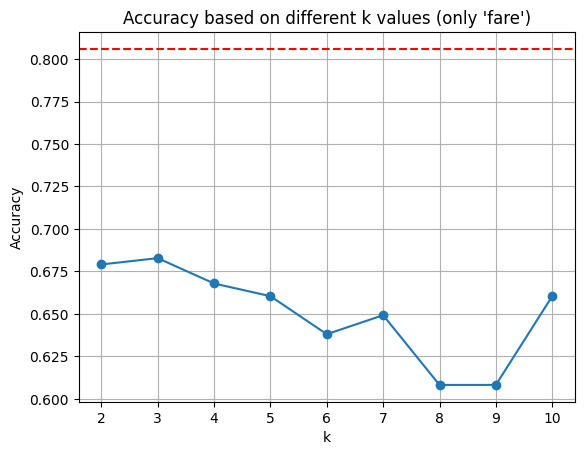

In [30]:
import matplotlib.pyplot as plt

y = k_values
x = accuracy_list

# Create the plot
plt.plot(y, x, marker='o')  # y on x-axis, x on y-axis (could reverse if needed)
plt.axhline(y=raw_accuracy, color='red', linestyle='--', label='Reference Accuracy')

# Add labels and title
plt.xlabel('k')       # Replace with your actual label
plt.ylabel('Accuracy')       # Replace with your actual label
plt.title('Accuracy based on different k values (only \'fare\')')     # Replace with your plot's title

# Optional: Show grid
plt.grid(True)

# Show the plot
plt.show()